In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

## In this project, we need to compare the old version of a website to the new version. 
    1. We need to analyze which version of the website is more preferred by users.
    2. We need to see if our new website can obtain a conversion rate of 15%. Then it can be launched to all the users.
    

In [8]:
effect_size = sms.proportion_effectsize(0.13,0.15)
required_n = sms.NormalIndPower().solve_power(effect_size,power = 0.8, alpha = 0.05,ratio = 1)
required_n = ceil(required_n)
print(required_n)

4720


In [5]:
version = pd.read_csv("C:/Users/asus/Desktop/Website_Version/ab_data.csv")

In [10]:
version.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [13]:
version.shape

(294478, 5)

In [11]:
version.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


1. We have a group feature where 'control' is the older version of the website and 'terminal' is the new version
2. The feature 'converted' is a binary feature. If it is '1', the user preferred the other version of the website. If it's '0', the user selected the same version of the website

In [12]:
pd.crosstab(version['group'], version['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [14]:
version['user_id'].value_counts

<bound method IndexOpsMixin.value_counts of 0         851104
1         804228
2         661590
3         853541
4         864975
           ...  
294473    751197
294474    945152
294475    734608
294476    697314
294477    715931
Name: user_id, Length: 294478, dtype: int64>

# We will check if there are any duplicate 'user_id' present.

In [17]:
session_counts = version['user_id'].value_counts(ascending = False)
multiple_users = session_counts[session_counts > 1].count()
print('{} users appear multiple times'.format(multiple_users))

3894 users appear multiple times


In [18]:
drop_users = session_counts[session_counts > 1].index


In [19]:
drop_users

Int64Index([637561, 821876, 643869, 938802, 916765, 690255, 737500, 680018,
            853835, 736746,
            ...
            774079, 859519, 670799, 766516, 694299, 764658, 692496, 711355,
            813603, 701024],
           dtype='int64', length=3894)

In [21]:
version = version[~version['user_id'].isin(drop_users)]
print(f'updated dataset has {version.shape[0]} entries')

updated dataset has 286690 entries


1. We only have 3894 duplicate users out of 294478. So it seems to be a small number. Let's go ahead and delete the rows. 

## Taking a Sample
1. We are not considering the whole data. Instead, we take a sample to see the user's behavior. 4720 random user_id's from our dataset for each of the 'group'


In [23]:
control_sample = version[version['group'] == 'control'].sample(n = required_n, random_state = 22)
treatment_sample = version[version['group'] == 'treatment'].sample(n = required_n, random_state = 22)


In [24]:
ab_test = pd.concat([control_sample,treatment_sample],axis  = 0)
ab_test.reset_index(drop = True, inplace = True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [25]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [26]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

## Let's have a look at some basic statistics. 

In [40]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


1. Our new design of the website is performing slightly better than our old version.

Text(0, 0.5, 'Converted')

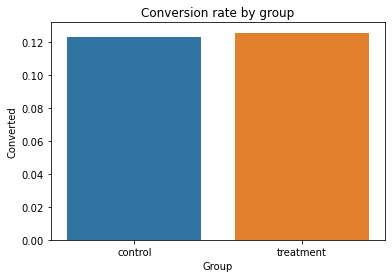

In [42]:
import seaborn as sns
sns.barplot(ab_test['group'], ab_test['converted'] , ci = False)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted')

In [47]:
control_results.count()

4720

## Performing Hypothesis Testing
1. If our p-value is less than alpha(0.05), then we can reject the null hypothesis and say users found new website design more appealing.
2. If we fail to reject the null hypothesis, it means that the older version is preferred by most of the users.

In [46]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
success = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [57]:
z_stat, pval = proportions_ztest(success, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(success, nobs=nobs, alpha = 0.05)

print(f'z-statistic : {z_stat}')
print(f'p_value: {pval}')
print(f'ci 95% for control group: [{lower_con}], [{upper_con}]')
print(f'ci 95% for treatment group:[{lower_treat}, [{upper_treat}]')

z-statistic : -0.342955932739339
p_value: 0.7316316123467367
ci 95% for control group: [0.11392532253557884], [0.13268484695594657]
ci 95% for treatment group:[0.11618019826523909, [0.13509098817543888]


## Conclusion
1. We can see the p-value is 0.73, which is greater than our alpha(0.05).
2. We cannot reject our null hypothesis in this case.
3. It means that the older version is preferred by most of the users than the new version
4. We can see the treatment group conversion rate is 13.5%. We need to achieve a 15% conversion rate to consider success in developing a new version of the website